In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns


PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
FireplaceQu     690
LotFrontage     259
GarageYrBlt      81
GarageCond       81
GarageType       81
dtype: int64


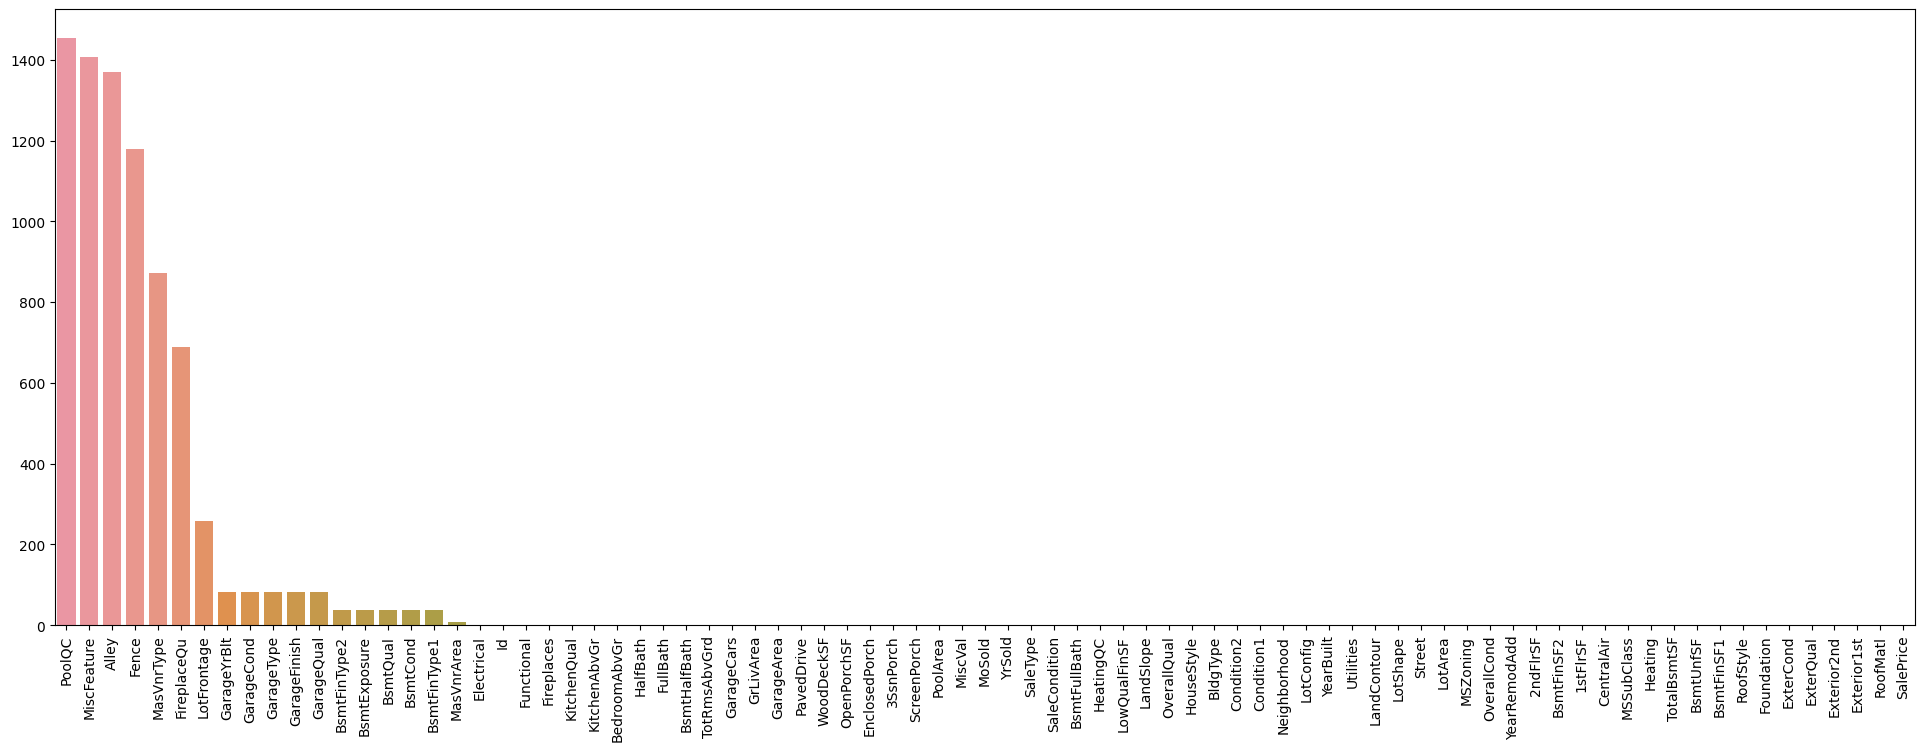

In [21]:
# Read the data
X_full = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv")
X_test_full = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv")

#X_full.info()

plt.figure(figsize=(24,8))
# columns with the most null values
cols_with_null=X_full.isnull().sum().sort_values(ascending=False)
# Let's visualize these columns
sns.barplot(x=cols_with_null.index,y=cols_with_null)
plt.xticks(rotation=90)
#plt.show();

print(cols_with_null.head(10))

In [22]:
## Cleaning Data -
def clean_data(data):
    data = data.drop(["MiscFeature", "Fence", "PoolQC","Id", "Alley", "FireplaceQu", "MasVnrType"], axis=1)
    return data

X_full = clean_data(X_full)
X_test_full = clean_data(X_test_full)


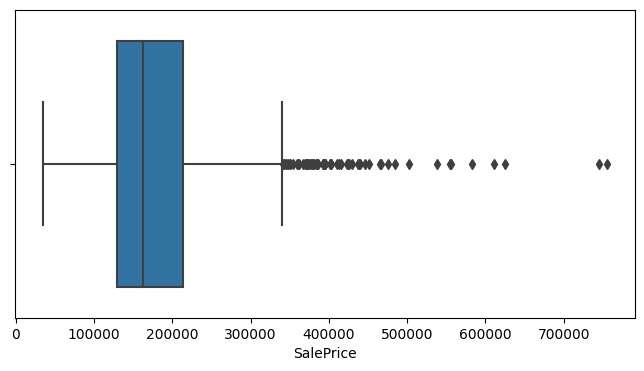

In [23]:
# drop outliers
plt.figure(figsize=(8,4))
sns.boxplot(x=X_full.SalePrice);
plt.show();


In [24]:
rows_2_drop=X_full[X_full['SalePrice']>X_full['SalePrice'].quantile(0.995)].index
X_full.drop(rows_2_drop,inplace=True)

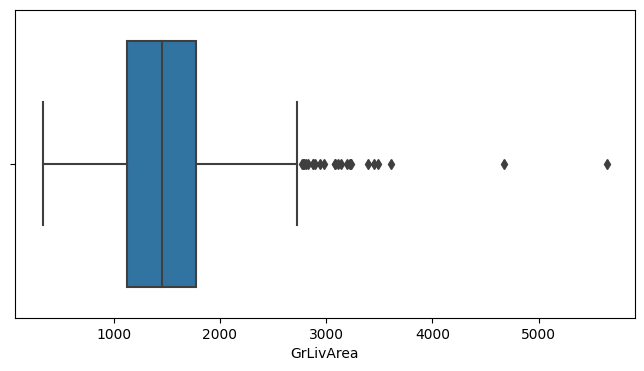

In [25]:
plt.figure(figsize=(8,4))
sns.boxplot(x=X_full.GrLivArea);
plt.show();

In [26]:
rows_2_drop=X_full[X_full['GrLivArea']>4000].index
X_full.drop(rows_2_drop,inplace=True)

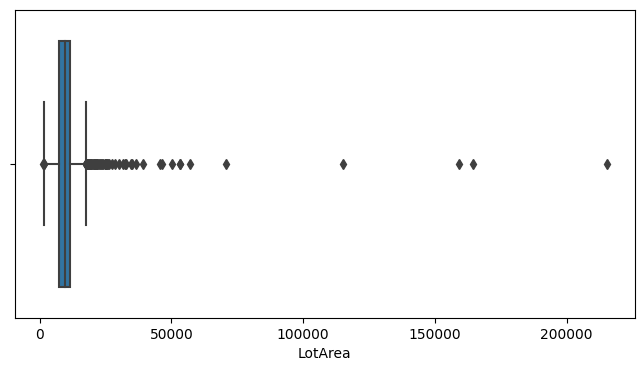

In [27]:
plt.figure(figsize=(8,4))
sns.boxplot(x=X_full.LotArea);
plt.show();

In [28]:
X_full[X_full['LotArea']>100000]
rows_2_drop=X_full[X_full['LotArea']>100000].index
X_full.drop(rows_2_drop,inplace=True)

In [29]:
# Remove rows with missing target, separate target from predictors
X_full.dropna(axis = 0, subset= ['SalePrice'], inplace = True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis = 1, inplace= True)

In [30]:
# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid  = train_test_split(X_full, y, test_size=0.2, train_size=0.8, random_state = 0)

In [31]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and
                    X_train_full[cname].dtype == 'object']

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if
                  X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [32]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy= 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [33]:
# Define the model
model1 = RandomForestRegressor(n_estimators=100, max_depth=3000)

model2 = XGBRegressor(n_estimators = 1100,
                      learning_rate = 0.02,
                      loss='squared_error',
                      subsample = 0.35,
                      random_state = 1) # Your code here

In [34]:
# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model2)])
# Preprocessing of training data, fit model
my_pipeline.fit(X_train, y_train)
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)
print('MAE', mean_absolute_error(y_valid, preds))

[21:53:24] WARNING: ../src/learner.cc:767: 
Parameters: { "loss" } are not used.

MAE 12192.128340517242


In [35]:
# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test)

# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index = False)